# Vivino users
> ZHAW CAS Machine Intelligence - Big Data Module - Sansar Choinyambuu, Gustavo Martinez

In this notebook a graph analysis of vivino users is done with help of Apache Spark's GraphFrames library.

https://www.vivino.com/ 
Vivino is an online wine marketplace powered by a community of over 40 million users. The users can rate and write reviews for wine and follow each other.

## Data scraping
The data was obtained from vivino.com using self-written scrapper available at:
https://github.com/sansar-choinyambuu/vivino-users/blob/main/scrape_top_ranked.py

Top 1000 users from following 10 countries were scraped along with their followers and followings, for this analysis.
For some users, vivino doesn't provide details unless API user is authenticated. Therefore not exactly 10k users were crawled. In the end it ended up being 4'949 users.
["fr", "it", "es", "us", "ch", "de", "ru", "gb", "au", "ca"]

***

Vivino exposes API's to get information on users and the followership:
- HTTP POST https://www.vivino.com/users/x/country_rankings - top ranked users for a country
  {
      "page": 1,
      "country_code": "ca"
  }
- HTTP GET http://app.vivino.com/api/users/mikhail-mikhail20 - user information
- HTTP GET http://app.vivino.com/api/users/mikhail-mikhail20/followers?start_from=0&limit=10 - followers of user
- HTTP GET http://app.vivino.com/api/users/mikhail-mikhail20/followers?start_from=0&limit=10 - following of user

## Read and prepare data

In [0]:
import pandas as pd
# data is available at https://github.com/sansar-choinyambuu/vivino-users
users_df = pd.read_pickle("/dbfs/FileStore/shared_uploads/choinsa1@students.zhaw.ch/vivino_top_ranked.pkl")
users_df["country"] = users_df["address"].map(lambda a: a["country"])
users_df["avatar"] = users_df["image"].map(lambda i: i["location"])
users_df["ratings"] = users_df["statistics"].map(lambda s: s["ratings_count"])
users_df["reviews"] = users_df["statistics"].map(lambda s: s["reviews_count"])
users_df["stories"] = users_df["statistics"].map(lambda s: s["activity_stories_count"])
users_df.head(3)

,address,alias,background_image,bio,followers,following,id,image,is_featured,seo_name,statistics,visibility,website,country,avatar,ratings,reviews,stories
0,"{'title': None, 'name': None, 'street': None, ...",Josean M,{'location': '//images.vivino.com/users/backgr...,None,[],[],30610918,{'location': '//images.vivino.com/avatars/defa...,False,josean.m1,"{'followers_count': 0, 'followings_count': 0, ...",all,None,es,//images.vivino.com/avatars/default_user.png,353,30,0
1,"{'title': None, 'name': None, 'street': None, ...",Jenna Eddie,{'location': '//images.vivino.com/users/backgr...,WSET Level 2,"[27729961, 23030936, 39078028, 26626339, 43496...","[19618445, 4866859, 23030936, 14061140, 506762...",9938486,{'location': '//images.vivino.com/avatars/m49f...,False,jenna.ed,"{'followers_count': 37, 'followings_count': 21...",all,None,gb,//images.vivino.com/avatars/m49fMjIDT06e2C8bxL...,1287,240,0
2,"{'title': None, 'name': None, 'street': None, ...",Beth VonVino,{'location': '//images.vivino.com/users/backgr...,A Texan in Hessen,"[7288914, 3015082, 3506287, 5082774, 1556134, ...","[3015082, 1556134, 2500201, 575520, 3837455, 7...",7032149,{'location': '//images.vivino.com/avatars/0046...,False,bebe.v,"{'followers_count': 393, 'followings_count': 1...",all,None,de,//images.vivino.com/avatars/0046q1hyae05926065...,352,286,0


In [0]:
users = users_df[["id", "seo_name", "alias", "country", "bio", "avatar", "ratings", "reviews", "stories"]]
followers = users_df[["id", "followers"]].explode("followers").rename(columns={"followers": "src", "id":"dst"})
following = users_df[["id", "following"]].explode("following").rename(columns={"id": "src", "following":"dst"})
followership = followers.append(following, ignore_index=True)
followership = followership.drop_duplicates()

# filter the followerships to include only users where we have the id's in users dataframe
users_ids = users["id"].to_numpy()
followership_filtered = followership[followership["src"].isin(users_ids) & followership["dst"].isin(users_ids)]

In [0]:
print(f"There are {len(users)} and {len(followership_filtered)} followership connections")

There are 4949 and 127864 followership connections

## Create graph

In [0]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = spark._jvm.org.apache.log4j
logging.getLogger("py4j").setLevel(logging.ERROR)

In [0]:
from graphframes import *

vertices = sqlContext.createDataFrame(users)
edges = sqlContext.createDataFrame(followership_filtered)

g = GraphFrame(vertices, edges)

In [0]:
print(f"Graph has {g.vertices.count()} vertices and {g.edges.count()} edges")

Graph has 4949 vertices and 127864 edges

## Analyze graph

### Mutual followers

In [0]:
# How many vivino top ranked users follow each other mutually
mutually_follow = g.find("(a)-[e1]->(b); (b)-[e2]->(a)").dropDuplicates()
print(f"Between {g.vertices.count()} top ranked vivino users there are {mutually_follow.count()} mutual following relationships")

Between 4949 top ranked vivino users there are 72132 mutual following relationships

### Degrees

In [0]:
from pyspark.sql import functions as F

# In degree statistics
g.inDegrees.agg(F.min(g.inDegrees.inDegree),
                F.max(g.inDegrees.inDegree),
                F.avg(g.inDegrees.inDegree),
                F.expr('percentile(inDegree, array(0.25))')[0].alias('%25'),
                F.expr('percentile(inDegree, array(0.50))')[0].alias('%50'),
                F.expr('percentile(inDegree, array(0.75))')[0].alias('%75'),
                F.expr('percentile(inDegree, array(0.90))')[0].alias('%90')).show()

# Out degree statistics
g.outDegrees.agg(F.min(g.outDegrees.outDegree),
                 F.max(g.outDegrees.outDegree),
                 F.avg(g.outDegrees.outDegree),
                 F.expr('percentile(outDegree, array(0.25))')[0].alias('%25'),
                 F.expr('percentile(outDegree, array(0.50))')[0].alias('%50'),
                 F.expr('percentile(outDegree, array(0.75))')[0].alias('%75'),
                 F.expr('percentile(outDegree, array(0.90))')[0].alias('%90')).show()

+-------------+-------------+------------------+---+---+----+----+
min(inDegree)|max(inDegree)| avg(inDegree)|%25|%50| %75| %90|
+-------------+-------------+------------------+---+---+----+----+
 1| 848|31.057566188972554|3.0|8.0|33.0|91.0|
+-------------+-------------+------------------+---+---+----+----+

+--------------+--------------+----------------+---+----+----+----+
min(outDegree)|max(outDegree)| avg(outDegree)|%25| %50| %75| %90|
+--------------+--------------+----------------+---+----+----+----+
 1| 839|32.7352790578597|3.0|12.0|38.0|84.0|
+--------------+--------------+----------------+---+----+----+----+

### Users by countries

In [0]:
g.vertices.groupBy("country").count().show()

+-------+-----+
country|count|
+-------+-----+
 au| 403|
 gb| 813|
 de| 393|
 es| 835|
 it| 824|
 ru| 843|
 fr| 838|
+-------+-----+

### Connected components

In [0]:
# Connected components
sc.setCheckpointDir("/FileStore/shared_uploads/choinsa1@students.zhaw.ch/project/checkpoints")
connected = g.connectedComponents()

In [0]:
connected.select("id", "component").groupBy("component").count().orderBy(F.desc("count")).show(5)

+---------+-----+
component|count|
+---------+-----+
 18419| 4265|
 18406474| 3|
 7224388| 3|
 37413341| 2|
 18732688| 2|
+---------+-----+
only showing top 5 rows

*Among the top ranked users there is one connected component with 4265 users out of total 4949 users*

In a connected component of the graph, any two users have path connecting them

### Strongly connected components

In [0]:
strongly_connected = g.stronglyConnectedComponents(maxIter=10)

In [0]:
strongly_connected.select("id", "component").groupBy("component").count().orderBy(F.desc("count")).show(5)

+---------+-----+
component|count|
+---------+-----+
 18419| 3637|
 31500869| 4|
 6869576| 3|
 31952401| 3|
 7224388| 3|
+---------+-----+
only showing top 5 rows

*Among the top ranked users there is one strongly connected component with 3637 users out of total 4949 users*

In a strongly connected component of the graph, there is a path in each direction between each pair of users.

### Community detection
Run static **Label Propagation Algorithm** for detecting communities in networks.

Each node in the network is initially assigned to its own community. At every superstep, nodes send their community affiliation to all neighbors and update their state to the mode community affiliation of incoming messages.

LPA is a standard community detection algorithm for graphs. It is very inexpensive computationally, although (1) convergence is not guaranteed and (2) one can end up with trivial solutions (all nodes are identified into a single community).

In [0]:
# run LPA with varying max iterations to find out the convergence for number of communities
communities_count = dict()

for i in range(1, 21):
  communities = g.labelPropagation(maxIter=i)
  communities_count[i] = communities.select("label").distinct().count()

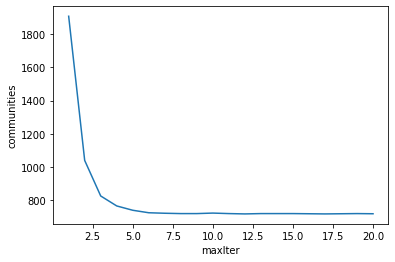

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

communities_count_df = pd.DataFrame({"maxIter": list(communities_count.keys()), "communities": list(communities_count.values())})
sns.lineplot(data = communities_count_df,
             x="maxIter", y="communities",
             markers = True,
             palette="flare")

In [0]:
communities_count_df.head(10)

,maxIter,communities
0,1,1908
1,2,1040
2,3,826
3,4,766
4,5,740
5,6,725
6,7,722
7,8,720
8,9,720
9,10,723


Running LPA algorithm with maximum iteration 6 converged to detection of 725 communities. Let us have a closer look at those 725 communities.

In [0]:
communities = g.labelPropagation(maxIter=6)
communities.show()

+--------+--------------------+--------------------+-------+--------------------+--------------------+-------+-------+-------+--------+
 id| seo_name| alias|country| bio| avatar|ratings|reviews|stories| label|
+--------+--------------------+--------------------+-------+--------------------+--------------------+-------+-------+-------+--------+
10777504| shelphur| Pavel S| ru|Some wine🍷 and d...|//images.vivino.c...| 1017| 884| 0|34100852|
29927616| evgenii.volkov2| Жареный Лебедь| ru| null|//images.vivino.c...| 365| 344| 0| 9713198|
26769360| stephane.pons1| Snop| fr| null|//images.vivino.c...| 273| 273| 0|14267364|
28144480| raffaele.nugnes| Raffaele Nugnes| it| null|//images.vivino.c...| 999| 0| 1|28144480|
 5424192| ranjand| RKD| gb| null|//images.vivino.c...| 288| 261| 4|34100852|
31085088| julian.reynolds| Julian R| au|Melbourne native....|//images.vivino.c...| 554| 546| 7|34100852|
22193296| jonathan.powles| Jonathan Powles| gb| null|//images.vivino.c...| 464| 439| 0|34100852|
34067312|bernd-michael.ser...|Bernd Michael Ser...| de| null|//images.vivino.c...| 126| 125| 2|34100852|
 8423728|m3cecca8d29f94bbc...| Erwin| gb| null|//images.vivino.c...| 673| 668| 0|34100852|
 8787904| matteo-trevis| Teo| it| null|//images.vivino.c...| 425| 238| 8|34100852|
 2730752|m99172cbb2e64a961...| Paul G| gb| null|//images.vivino.c...| 448| 447| 0|34100852|
34178288| vitalii.timokhin| Виталий Тимохин| ru|Пью не много, в в...|//images.vivino.c...| 142| 142| 1| 9713198|
27811616| jose-manuel.castro2| Jose Manuel Castro| es| null|//images.vivino.c...| 100| 93| 0|34100852|
 3864368| antoniosanchez8| Antonio Sanchez| es|20+ years experie...|//images.vivino.c...| 521| 519| 0|34100852|
 2128608| natalia.bog| Natalia Bogdanova| ru| null|//images.vivino.c...| 300| 263| 1| 9713198|
 1571600| ramsayl| Ramsay Longstaff| au| #howgoodiswine?|//images.vivino.c...| 1217| 1212| 0|34100852|
 4766848| nick-rowan| Nick Rowan| gb|WSET III approved...|//images.vivino.c...| 6829| 6803| 44|34100852|
14521632| alb7| Alberto| es| null|//images.vivino.c...| 1307| 841| 0|34100852|
15109088| christy.whi| Crystal Rouge| gb|Full Body, Brick ...|//images.vivino.c...| 295| 244| 1|34100852|
 4925760| mikhail.lukichev| Mikhail.L| fr|just passionate a...|//images.vivino.c...| 1457| 1032| 0|14267364|
+--------+--------------------+--------------------+-------+--------------------+--------------------+-------+-------+-------+--------+
only showing top 20 rows

In [0]:
communities.groupBy("label").count().sort(F.desc("count")).show()

+--------+-----+
 label|count|
+--------+-----+
34100852| 2906|
 9713198| 651|
14267364| 585|
 2084133| 62|
28996030| 5|
37362567| 4|
 3122410| 3|
34329672| 3|
38808370| 3|
27853799| 3|
43365419| 3|
32462109| 2|
32927918| 2|
27497059| 2|
 5367268| 2|
18406474| 2|
28144480| 1|
 8831888| 1|
 3212832| 1|
27628096| 1|
+--------+-----+
only showing top 20 rows

Out of total 725 communities there are only 4 bigger communities with more than 5 users. Let us try to get some sense about these bigger communities with some explorative analysis.

## Visualizations
Let us visualize the fourth biggest community with id 2084133, that contains 62 users.

In [0]:
!pip install networkx

In [0]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import numpy as np

def CreateNxGraph(edge_list):
    G=nx.Graph()
    for row in edge_list.rdd.collect():
        G.add_edge(row["src"],row["dst"])
    return G

def PlotGraph(G):
    d = dict(G.degree)
    plt.figure(3, figsize=(20,20)) 
    pos = nx.kamada_kawai_layout(G,scale=2)
    #pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
    nx.draw(G,
            pos = pos, 
            node_color='lightblue', 
            with_labels=True, 
            nodelist=d, 
            node_size=[d[k]*100 for k in d])

In [0]:
# filter id's of users in chosen community
chosen_community_label = "2084133"
chosen_community_users = communities.filter(f"label = {chosen_community_label}").select("id").rdd.flatMap(lambda x: x).collect()
community_edges = g.edges.where(F.col("src").isin(chosen_community_users)).where(F.col("dst").isin(chosen_community_users))

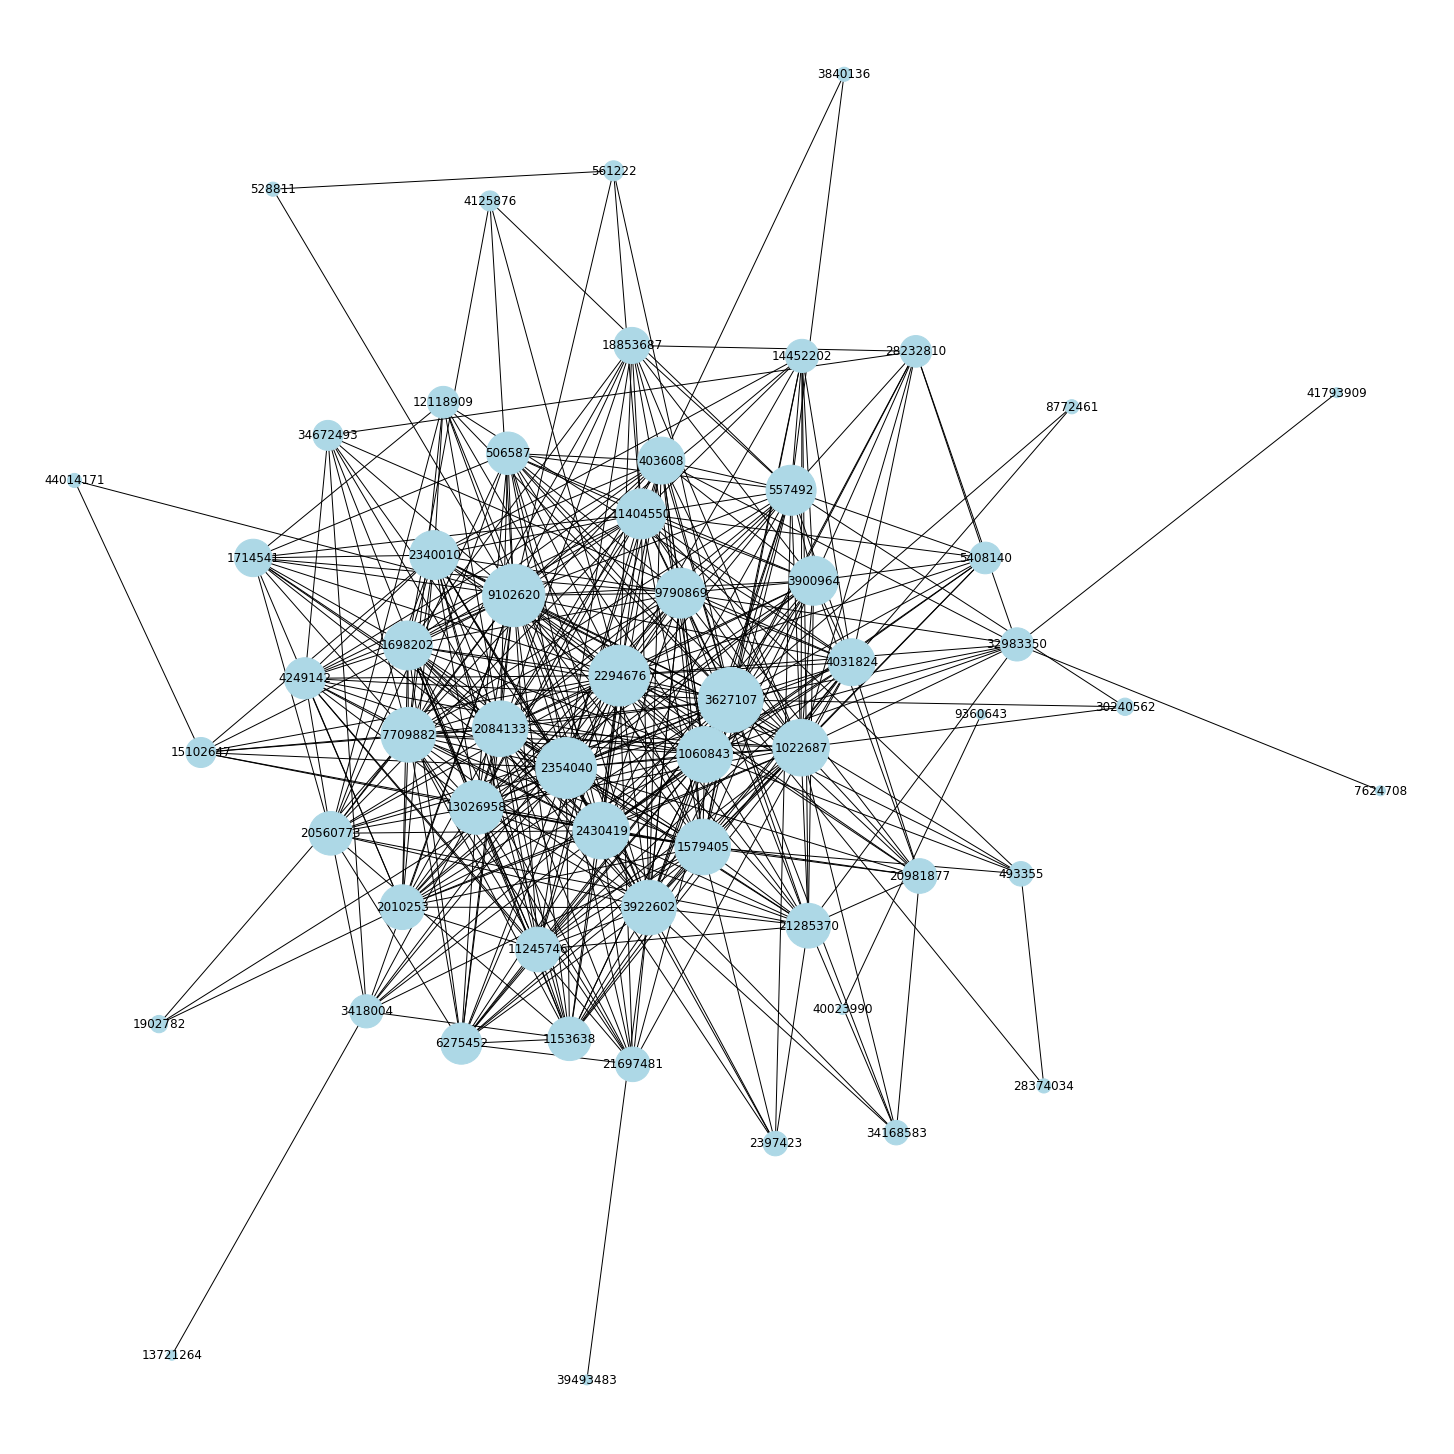

In [0]:
G = CreateNxGraph(community_edges)
PlotGraph(G)

### Interactive plot

In [0]:
!pip install pyvis

In [0]:
from pyvis.network import Network

nt = Network(height="800px", width="1600px", bgcolor="#222222", font_color="white", heading = "Vivino users in a community")
nt.barnes_hut()
nt.show_buttons(filter_=['physics'])
nt.from_nx(nx_graph = G)

# add hover over texts
def extract_user_info(id):
  info = dict()
  usr = communities.filter(f"id = {id}").collect()[0] 
  info["seo_name"] = usr["seo_name"]
  info["alias"] = usr["alias"]
  info["country"] = usr["country"]
  info["bio"] = usr["bio"]
  info["ratings"] = usr["ratings"]
  info["reviews"] = usr["reviews"]
  info["stories"] = usr["stories"]
  
  return "<br>".join([f"{k} - {v}" for (k,v) in info.items()])
  
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node["title"] = extract_user_info(node["id"])
    node["value"] = len(neighbor_map[node["id"]])

html_path = "/dbfs/FileStore/shared_uploads/choinsa1@students.zhaw.ch/project/nx.html"
nt.save_graph(html_path)

In [0]:
html_file_content = open(html_path, 'r').read()
displayHTML(html_file_content)

Vivino users in a community 
 

<!-- 
-->

From above interactive plot, it becomes clear that this community is a community of russian vivino users

The generated html can be downloaded from https://adb-8447367562806996.16.azuredatabricks.net/files/shared_uploads/choinsa1@students.zhaw.ch/project/nx.html